In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [2]:
p65folder = './images/places365/'
imfolder = p65folder+'val_large/'
imname = 'Places365_val_'

## Load in Image Metadata 

### Match Filenames to Category ID

In [3]:
colnames = ['filename','category_ID']
df_fname_cid = pd.read_table(p65folder+'places365_val.txt',sep=' ',header=None,names=colnames)
df_fname_cid.head(5)

,filename,category_ID
0,Places365_val_00000001.jpg,165
1,Places365_val_00000002.jpg,358
2,Places365_val_00000003.jpg,93
3,Places365_val_00000004.jpg,164
4,Places365_val_00000005.jpg,289


### Match Category ID to Category Name

In [4]:
colnames = ['category','category_ID']
df_cat_cid = pd.read_table(p65folder+'categories_places365.txt',sep=' ',header=None,names=colnames)
df_cat_cid.head(5)

,category,category_ID
0,/a/airfield,0
1,/a/airplane_cabin,1
2,/a/airport_terminal,2
3,/a/alcove,3
4,/a/alley,4


### Match Category Name to Indoor/Outdoor Manmade/Natural Labels

In [19]:
df_cat_lab = pd.read_csv(p65folder+'SceneHierarchy_Places365.csv', header=1)
df_cat_lab = df_cat_lab.iloc[:, 0:4] #don't need more specific than indoor/outdoor manmade/natural
df_cat_lab.head(5)

,category,indoor,"outdoor, natural","outdoor, man-made"
0,'/a/airfield',0,0,1
1,'/a/airplane_cabin',1,0,0
2,'/a/airport_terminal',1,0,0
3,'/a/alcove',1,0,0
4,'/a/alley',0,0,1


### Put these into one easy-to-use table together

In [35]:
df = pd.concat([df_cat_cid, df_cat_lab.iloc[:,1:]], axis=1)
df = pd.merge(df_fname_cid, df, on=['category_ID']).sort_values('filename')
df.head(5)

,filename,category_ID,category,indoor,"outdoor, natural","outdoor, man-made"
0,Places365_val_00000001.jpg,165,/g/greenhouse/indoor,1,0,0
100,Places365_val_00000002.jpg,358,/w/wet_bar,1,0,0
200,Places365_val_00000003.jpg,93,/c/clean_room,1,0,0
300,Places365_val_00000004.jpg,164,/g/golf_course,0,1,1
400,Places365_val_00000005.jpg,289,/r/rock_arch,0,1,0


## Three Example Images

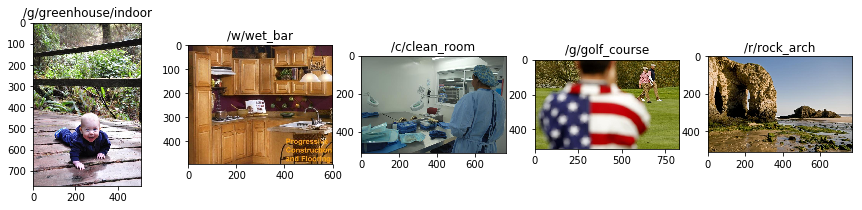

In [71]:
plt.figure(figsize=(15,3))
nims = 5

for imn in range(nims):
    imn = imn+1
    testim_fname = imname+'0000000'+str(imn)+'.jpg'
    testim = cv2.imread(imfolder+testim_fname)
    testim = cv2.cvtColor(testim, cv2.COLOR_BGR2RGB) #fix colors
    testim_cat = df.loc[df['filename'] == testim_fname,'category'].item()
    #print(testim_cat)
    plt.subplot(1,nims,imn)
    plt.imshow(testim)
    plt.title(testim_cat)


In [45]:
imfolder+imname+'00000001.jpg'

'./images/places365/val_large/Places365_val_00000001.jpg'

In [ ]:
plt.subplot(1,2,1)
plt.imshow(testim1)
